import quandl module and other relatives, get the data via its API:

In [21]:
import quandl

#import packages
import pandas as pd
import numpy as np

#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline

#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

small_data = quandl.get("EOD/HD", authtoken="nUnXVC-wyxYCVreWU7nY", start_date="2014-01-01")
df = small_data
df.head()

,Open,High,Low,Close,Volume,Dividend,Split,Adj_Open,Adj_High,Adj_Low,Adj_Close,Adj_Volume
Date,,,,,,,,,,,,
2014-01-02,82.11,82.57,81.80,82.02,4253400.0,0.0,1.0,73.187302,73.597315,72.910989,73.107082,4253400.0
2014-01-03,81.91,82.48,81.83,81.89,3897900.0,0.0,1.0,73.009035,73.517095,72.937729,72.991209,3897900.0
2014-01-06,81.65,81.98,81.10,81.10,11188800.0,0.0,1.0,72.777289,73.071428,72.287056,72.287056,11188800.0
2014-01-07,81.31,81.92,81.08,81.50,4630900.0,0.0,1.0,72.474236,73.017949,72.269229,72.643589,4630900.0
2014-01-08,81.54,81.94,81.03,81.93,4662300.0,0.0,1.0,72.679242,73.035775,72.224663,73.026862,4662300.0


Let's first take a look at the data:

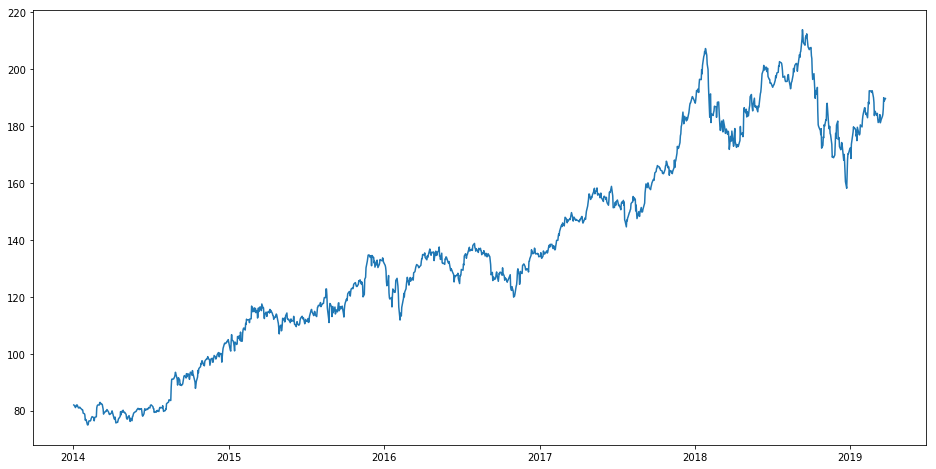

In [22]:
df['Date'] = pd.to_datetime(df.index,format='%Y-%m-%d')

#plot
plt.figure(figsize=(16,8))
plt.plot(df['Close'], label='Close Price history')

In this notebook, we make one prediction based on 60 days data before the predicting date. Thus, we split 1060 length of data used for training (1000 + 60), in this way we have 1000 training samples. e.g. the first sample is `data=dataset[0:60], label=dataset[61]`. And the data remained are used for validation.

In [23]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

#creating dataframe
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]

#setting index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

#creating train and test sets
dataset = new_data.values

train = dataset[0:1060,:]
valid = dataset[1060:,:]

Then let's prepare the data as we say above:

In [26]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train.shape, y_train.shape

/home/litchy/Programs/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


((1000, 60), (1000,))

Okay now we are almost done, just one more, LSTM requires input data to be 3-d, `(batch_size, sequence_length, feature_dim)`, so let's resize the data and take a look:

In [27]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
x_train.shape, y_train.shape

((1000, 60, 1), (1000,))

Now let's train the data using LSTM:

In [59]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=4, batch_size=1, verbose=2)

Epoch 1/4
 - 63s - loss: 0.0026
Epoch 2/4
 - 62s - loss: 6.5563e-04
Epoch 3/4
 - 56s - loss: 5.7717e-04
Epoch 4/4
 - 56s - loss: 5.3560e-04


Before doing the prediction, don't forget to scale the data using the same scaler, then let's take a look of data shape:

In [29]:
#predicting 246 values, using past 60 from the train data
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
train.shape, valid.shape, inputs.shape # input is valid + 60

((1060, 1), (255, 1), (315, 1))

Now we are almost ready to predict. To make the comparison of the old article, I post both predict approach here. If you are not interested in the wrong one, just ignore all the operations relating to `X_1`.

And note that directly assigning value would just copy the reference of object. To make a copy of the data, we use following code `np.copy`:

In [65]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
    
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

X_1 = np.copy(X_test)
X_2 = np.copy(X_test)
X_test.shape

(255, 60, 1)

This is the predicting code in old article. Please be careful, it is using existed data all the time. For example, in this notebook, our purpose is to predict 246 days of prices based on 246 * 60 days of data. The first prediction should be using 1 to 60 days data to predict 61-th day data. Then we should use 2 to 61 days data to predict 62-th day data. But, we should not use the 61-th day real data, instead, we should use the result of first prediction, which is 61-th day predicted data.

This is why the original article has gone into a wrong way. By the way, I still run its code to get the result for comparison.

In [60]:
old_closing_price = model.predict(X_1)
old_closing_price = scaler.inverse_transform(old_closing_price)

In [61]:
old_closing_price

array([[178.93715],
       [178.84874],
       [178.85837],
       [178.05128],
       [176.08372],
       [175.6612 ],
       [175.4253 ],
       [175.41049],
       [176.58989],
       [176.23495],
       [175.6768 ],
       [176.30609],
       [177.73268],
       [177.59544],
       [176.28128],
       [175.15302],
       [174.204  ],
       [173.77182],
       [173.51736],
       [173.9409 ],
       [174.67487],
       [176.87819],
       [178.14607],
       [178.65305],
       [178.85669],
       [178.38492],
       [178.10875],
       [180.59079],
       [183.66269],
       [185.54607],
       [186.30005],
       [186.71259],
       [185.90608],
       [185.42557],
       [184.70265],
       [184.59717],
       [185.20592],
       [186.20844],
       [188.12497],
       [190.08727],
       [190.45407],
       [189.53862],
       [188.00887],
       [187.35495],
       [188.00807],
       [188.05972],
       [187.85097],
       [187.7665 ],
       [187.6682 ],
       [187.0123 ],


Now let's get the right one, every time when we finish a prediction, we cover the real value with predicted value and it could be used in next day prediction.

In [36]:
old_closing_price.shape

(255, 1)

We need to be cautious of the data shape here. Every time we can only predict one sample, which is (1, 60, 1) 3-d array and get (1, 1) 2-d array result.

In [66]:
new_closing_price = np.zeros((255,1))
for i in range(X_2.shape[0]):
    new_closing_price[i][0] = model.predict(X_2[i].reshape(1, -1, 1))[0][0]
    if i < X_2.shape[0] - 1:
        X_2[i+1][-1][0] = new_closing_price[i][0]
        # print (X_2[i+1])    

#closing_price = model.predict(X_test)
new_closing_price = scaler.inverse_transform(new_closing_price)
new_closing_price

array([[178.9371582 ],
       [179.09319649],
       [179.1960907 ],
       [179.27827362],
       [178.41829987],
       [176.29510307],
       [175.92704311],
       [175.77294186],
       [175.82128475],
       [177.14582214],
       [176.73050369],
       [176.08507637],
       [176.77954193],
       [178.32594341],
       [178.09850002],
       [176.58612068],
       [175.35804558],
       [174.38915131],
       [174.00772255],
       [173.81051003],
       [174.33446754],
       [175.15887119],
       [177.54331001],
       [178.82088692],
       [179.2225634 ],
       [179.31780884],
       [178.71499611],
       [178.37470848],
       [181.07603333],
       [184.34416206],
       [186.20738335],
       [186.80916962],
       [187.07984844],
       [186.08876114],
       [185.51862953],
       [184.75137646],
       [184.68711517],
       [185.40848389],
       [186.53018806],
       [188.59625084],
       [190.65673431],
       [190.94258652],
       [189.8422393 ],
       [188

In [43]:
#for plotting
train = new_data[:1060]
valid = new_data[1060:]
valid.values

array([[178.16],
       [178.02],
       [175.29],
       [171.8],
       [176.38],
       [174.68],
       [174.76],
       [178.24],
       [172.9],
       [173.76],
       [177.44],
       [179.13],
       [174.45],
       [172.51],
       [173.49],
       [172.86],
       [173.36],
       [172.8],
       [174.43],
       [174.91],
       [179.85],
       [177.08],
       [177.01],
       [177.66],
       [176.26],
       [177.39],
       [185.72],
       [186.46],
       [184.8],
       [184.63],
       [185.91],
       [183.19],
       [185.03],
       [183.56],
       [185.04],
       [186.36],
       [187.16],
       [190.31],
       [191.08],
       [187.98],
       [186.38],
       [185.33],
       [187.42],
       [189.79],
       [186.87],
       [186.67],
       [187.15],
       [186.85],
       [185.0],
       [187.09],
       [186.55],
       [187.35],
       [191.36],
       [191.94],
       [193.59],
       [196.17],
       [198.33],
       [199.64],
       [201.31],
  

/home/litchy/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


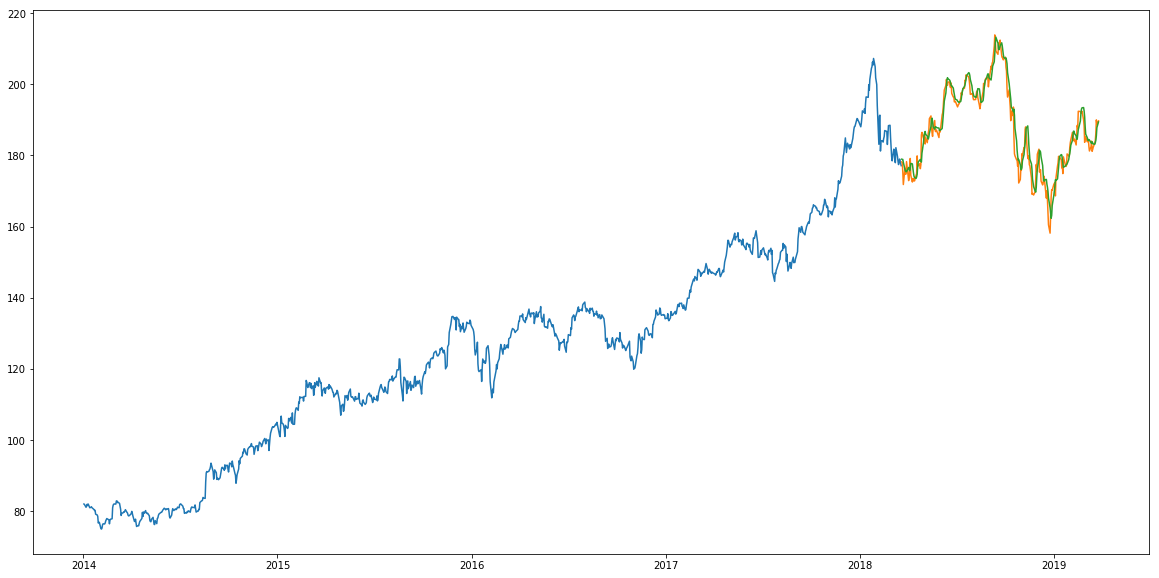

In [63]:
valid['OldPredictions'] = old_closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','OldPredictions']])

/home/litchy/Programs/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


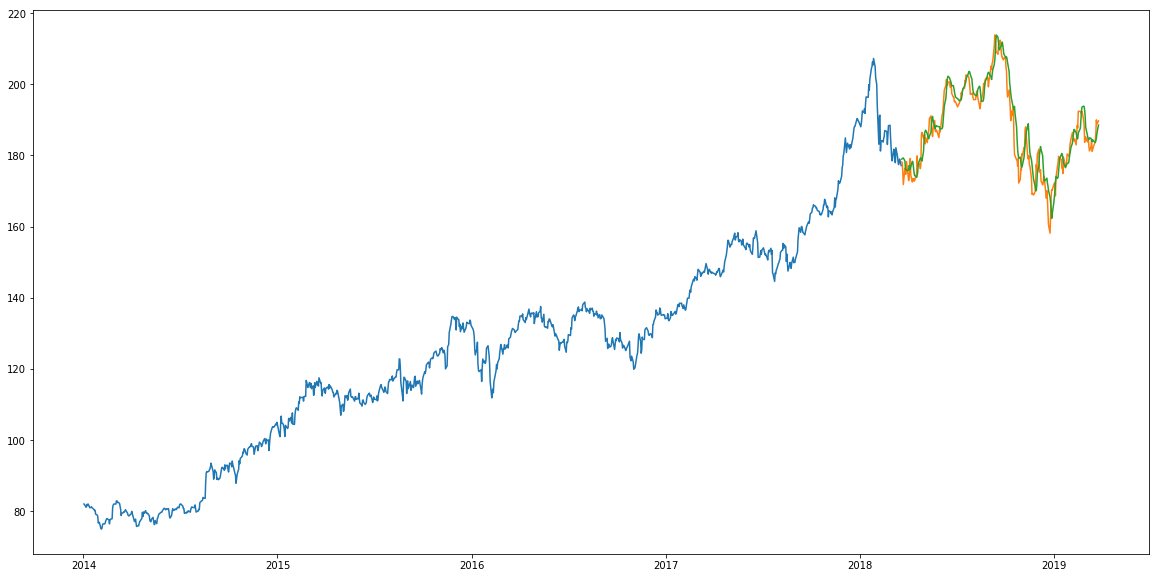

In [67]:
valid['NewPredictions'] = new_closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','NewPredictions']])

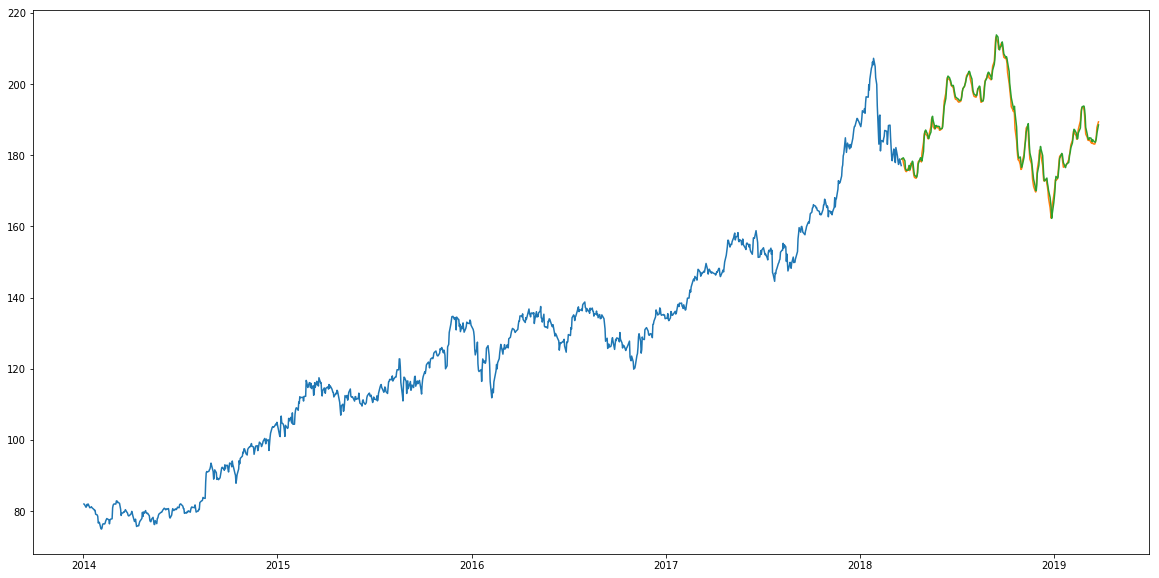

In [68]:
plt.plot(train['Close'])
plt.plot(valid[['OldPredictions','NewPredictions']])

Wow!